In [1]:
%matplotlib inline

In [2]:
#import gym modules
import gym
import gym_ple
from gym.wrappers import Monitor
import pygame

couldn't import doomish
Couldn't import doom


In [3]:
# import pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

from torch.autograd import Variable

In [4]:
# import time to slow down rendering speed
import time
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from itertools import count

In [5]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [6]:
# create gym env
env = gym.make('Snake-v0')
outdir='/tmp/random-agent-results'
env = Monitor(env, directory=outdir, force=True)
env.seed(1234)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods. Compatibility code invoked.


In [7]:
Transition = namedtuple('Transition',
                        ('prev_state', 'action', 'frame_stack', 'reward'))

# Transition = namedtuple('Transition',
#                         ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(12, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(32*5*5, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #print("1", x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        #print("2", x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print("3", x.shape)
#        xx = x.view(1, -1)
#        print("final", x.shape)
 #       print(xx.shape)
        return self.head(x.view(x.size(0), -1))

In [9]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(100000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
#         print("not random")
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
#         print("random")
        return LongTensor([[random.randrange(2)]])


episode_durations = []
episode_rewards = []
epi_food_obtained = []


def plot_durations():
    plt.figure(2, figsize = (15,5))
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.subplot(1,3,1)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), 'r')
        
        
    plt.subplot(1,3,2)
    plt.title('Total Reward vs episodes')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(range(len(episode_rewards)), episode_rewards, 'r')
    
    plt.subplot(1,3,3)
    plt.title('# Food obtained')
    plt.xlabel("Episode")
    plt.ylabel("# Food obtained")
    plt.plot(range(len(epi_food_obtained)), epi_food_obtained, 'r')
    plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())


In [10]:
last_sync = 0
from IPython.core.debugger import Tracer

def optimize_model():
    global last_sync
    from IPython.core.debugger import Tracer
    
    # if population of the replay memory is not enough, don't do anything
    if len(memory) < BATCH_SIZE:
        return
    # uncomment to enable debugger
    # Tracer()()
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.frame_stack)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.frame_stack
                                                if s is not None]),
                                     volatile=True)
    
#     for i in range(len(batch.prev_state)):
#         if batch.prev_state[i] is None:
#             print("None")
#         else:
#             print(batch.prev_state[i].type())

    state_batch = Variable(torch.cat(batch.prev_state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch)
    state_action_values = state_action_values.gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
from PIL import Image
resize = T.Compose([T.ToPILImage(),
                    T.ToTensor()])

def get_screen(frame):
#     frame = torch.from_numpy(preprocess(frame)).unsqueeze(0)
#    screen = preprocess(frame)
    screen = frame.transpose(
         (2, 0, 1))  # transpose into torch order (CHW)
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 1 food
Running episode #1; episode duration is 9 steps


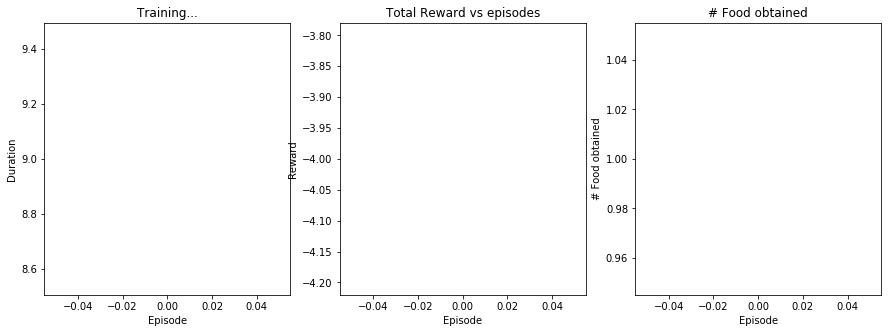

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <cla

Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 18 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 18 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN:

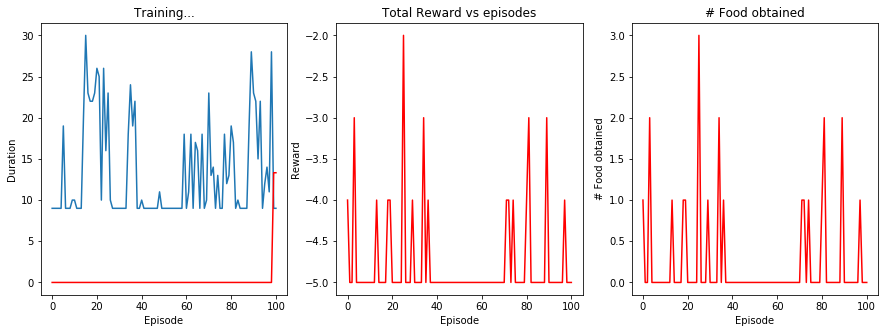

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <cla

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 10 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 10 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <cl

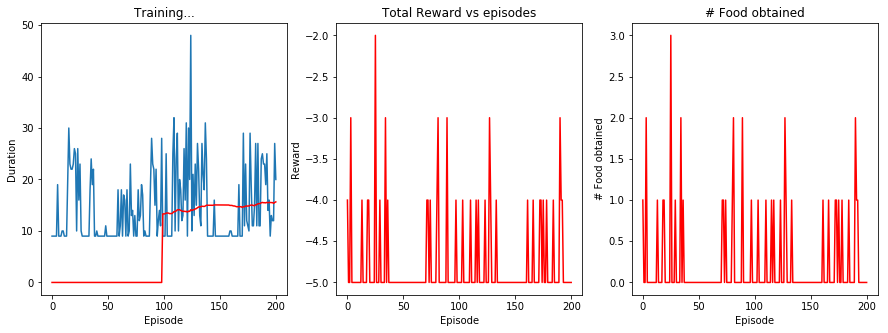

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as 

Crashed after 16 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 0 food
W

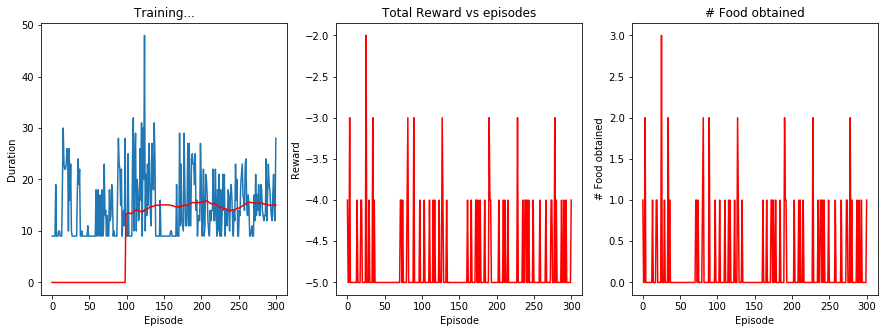

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 16 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 17 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 18 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 27 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 27 steps, obtained 0 food
W

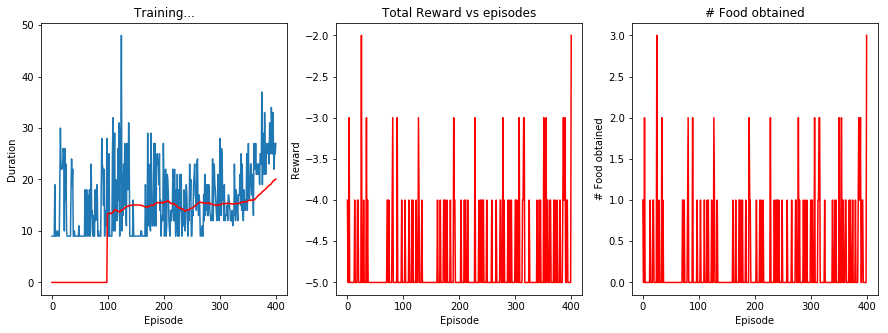

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 28 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 39 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 43 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 27 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 28 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
W

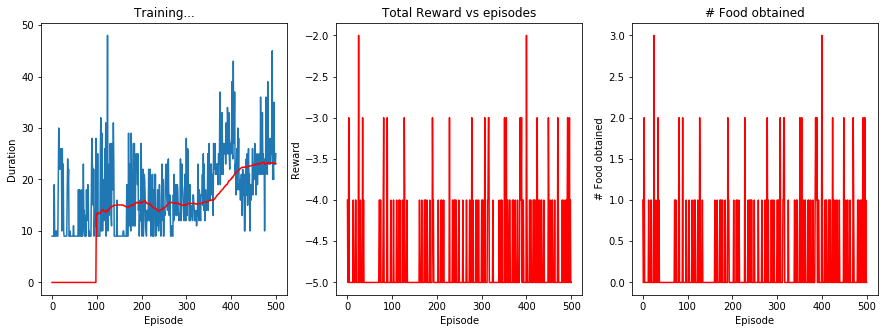

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
W

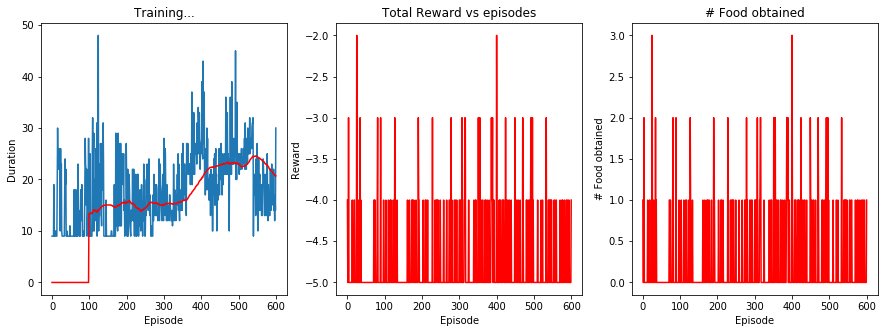

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 16 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 16 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 18 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 41 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 40 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 29 steps, obtained 1 food
W

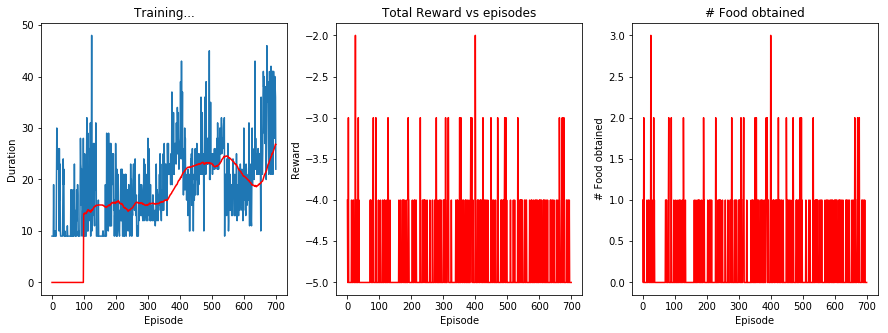

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 37 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 40 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 29 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 30 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 20 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
W

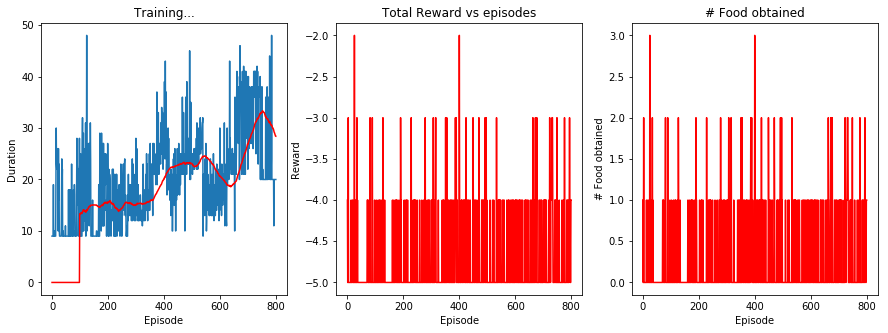

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 39 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
W

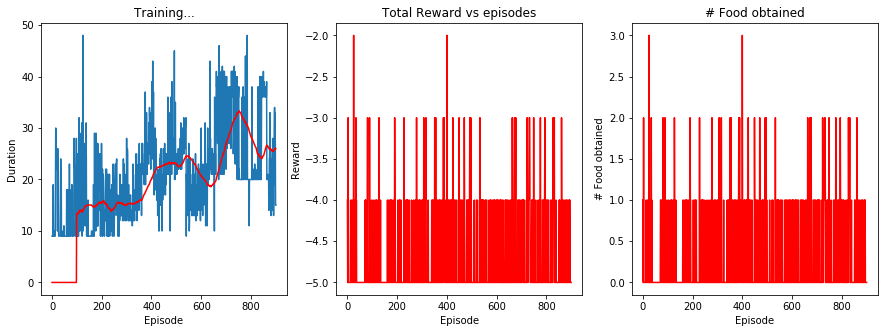

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 28 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 33 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 28 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 22 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 37 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 39 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 53 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 2 food
W

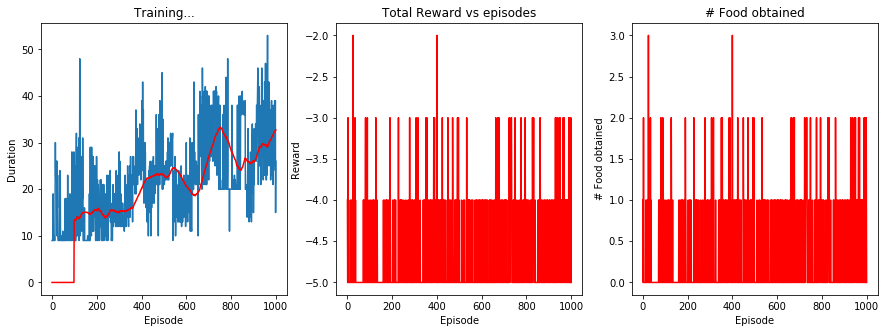

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 33 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 34 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 37 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 35 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 35 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 33 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 33 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 37 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 33 steps, obtained 1 food
W

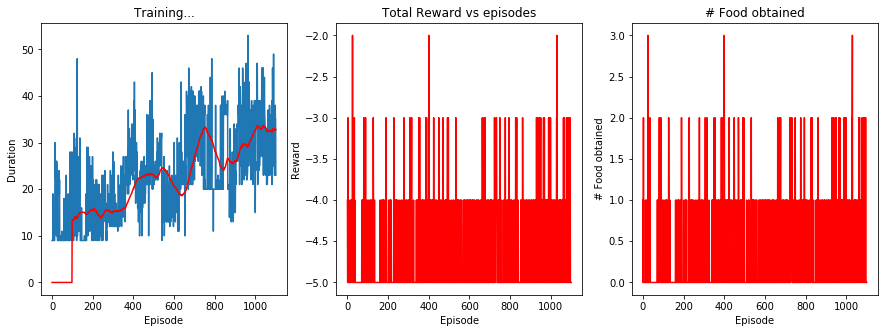

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 39 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 37 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 38 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 39 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 50 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 43 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 50 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 36 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 43 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 48 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 44 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 35 steps, obtained 0 food
W

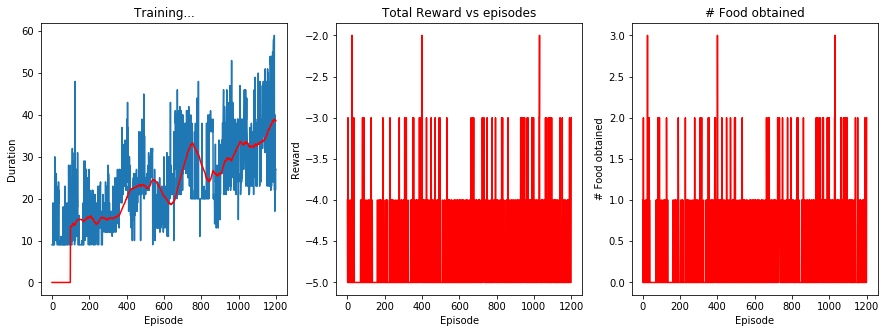

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 42 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 42 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 28 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
W

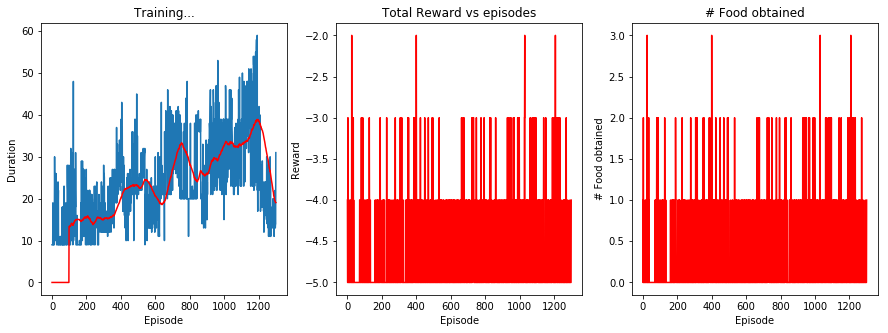

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 44 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 3 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 31 steps, obtained 0 food
W

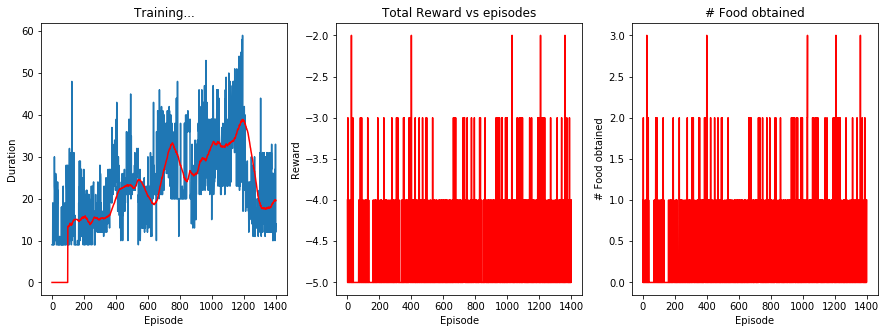

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 10 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 17 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 17 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 26 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 16 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 15 steps, obtained 0 food
W

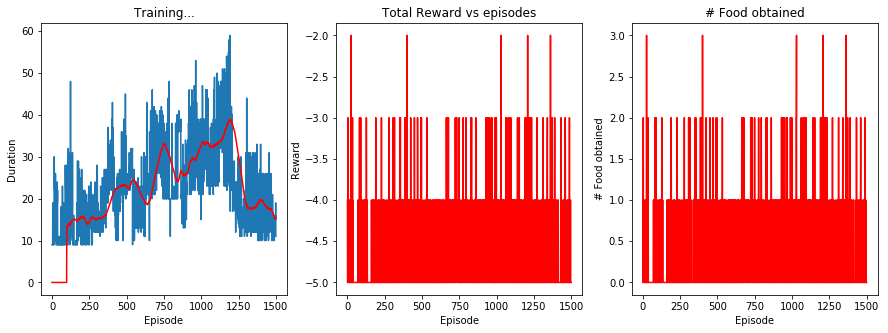

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 10 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 16 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 1 food
W

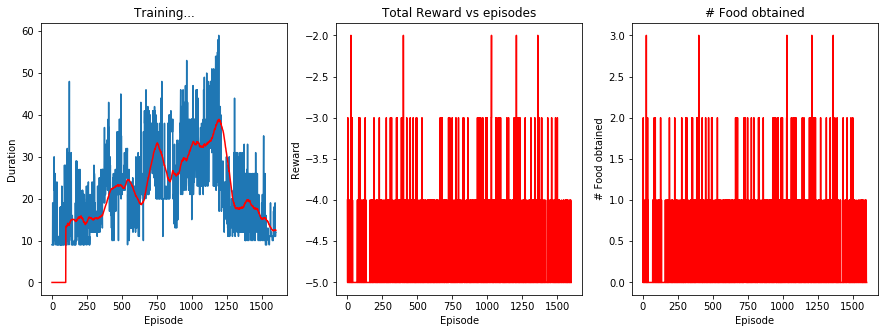

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 18 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN:

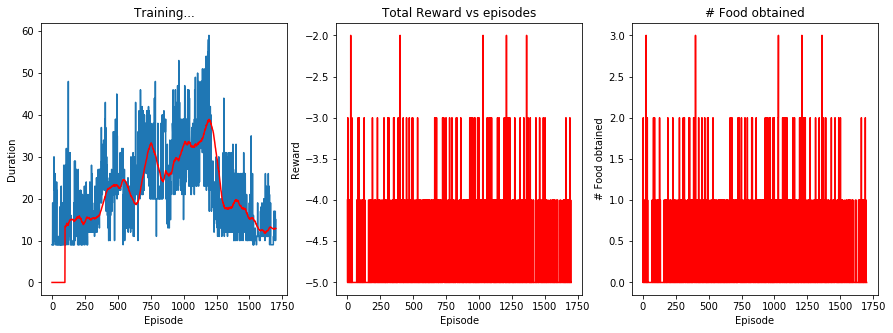

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 14 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 3 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: 

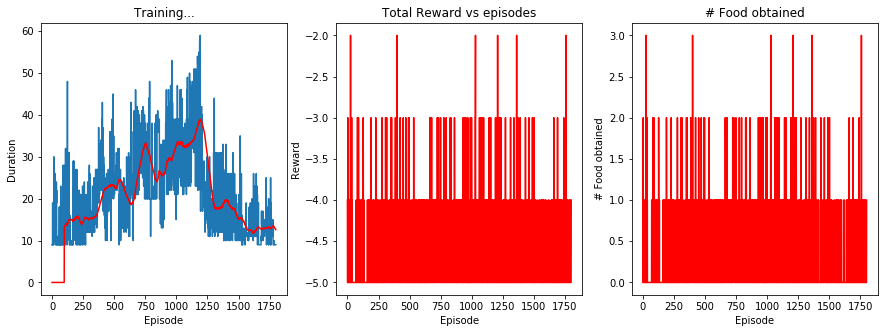

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 10 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 19 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <cl

Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 13 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 27 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 25 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 22 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
W

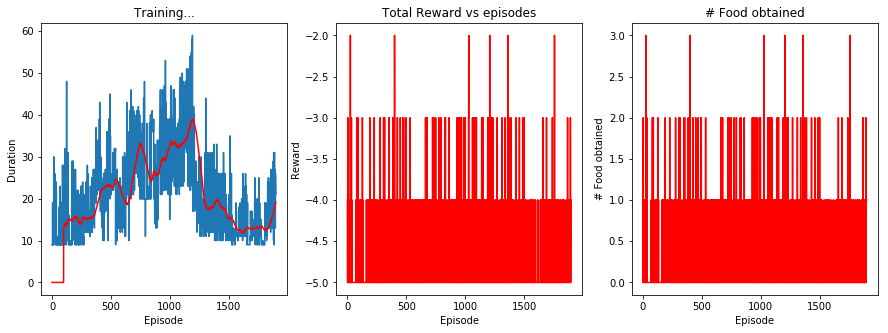

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 23 steps, obtained 1 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 21 steps, obtained 2 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 31 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype a

Crashed after 12 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 20 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 11 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 9 steps, obtained 0 food
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
Crashed after 24 steps, obtained 1 food
WARN:

In [12]:
# main
from IPython.core.debugger import Tracer

plot_every = 100
print_every = 100
num_episodes = 2000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    # get initial observation
    init_obs = env.reset()
    current_screen = get_screen(init_obs)
    state = current_screen
    current_reward = 0
    food_obtained = 0
#     frame_stack = state

    prev_state = torch.cat([state,state,state,state],1)
    
    # Select and perform initial action
    for t in count():
        action = select_action(prev_state)

        # init stack reward
        stack_reward = 0
        
        for j in count():
            # loop 4 times to and perform the same action 4 times
            next_obs, reward, done, _ = env.step(action[0, 0])
            
            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(next_obs)
            
            if reward == 1:
                food_obtained += 1
#                 print("food obtained, now eaten %d foods" % food_obtained)
#                 reward = 1000
#             elif reward == 0:    
#                 # give a negative reward for each step taken
#                 reward = 0
            elif reward == -5:
                print('Crashed after %d steps, obtained %d food' % (t + 1, food_obtained))
                # hits a wall
#                 reward = -500
                
            # update current total reward
            current_reward += reward
            stack_reward += reward
                
            if not done:
                next_state = current_screen - last_screen
            else:
                next_state = None
                frame_stack = None
                break
            
            # concatenate frames
            if j ==0:
                frame_stack = next_state
            else:
                frame_stack = torch.cat((frame_stack, next_state), 1)
            
            if j == 3:
                break
            
        
#             # update current total reward
#             current_reward += reward
#             stack_reward += reward
            
#              # Observe new state
#             last_screen = current_screen
#             current_screen = get_screen(next_obs)
#             if not done:
#                 next_state = current_screen - last_screen
#             else:
#                 next_state = None
            
        
        
        reward = Tensor([stack_reward])
            
        
#         if t == 0:
#             continue

        # Store the transition in memory
#         Tracer()()
        if not done:
            memory.push(prev_state, action, frame_stack, reward)
            
        # Move to the next state
        prev_state = frame_stack

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(current_reward)
            epi_food_obtained.append(food_obtained)
            if i_episode % print_every == 0:
                print("Running episode #%d; episode duration is %d steps" % (len(episode_durations), t+1))
            if i_episode % plot_every == 0:
                plot_durations()
            break

print('Complete')


In [ ]:
env.close()
# reset gym env
env = gym.make('Snake-v0')
outdir='/tmp/random-agent-results'
env = Monitor(env, directory=outdir, force=True)
env.seed(1234)

In [ ]:
class Agent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def random_act(self, observation, reward, done):
        return self.action_space.sample()
    
    # 0 : nothing, 1: left, 2: right
    def fix_act(self):
        return 1


In [ ]:
len(memory.memory)

In [ ]:
env = gym.make('Snake-v0')
outdir='/tmp/random-agent-results'
env = Monitor(env, directory=outdir, force=True)
env.seed(1234)
agent = Agent(env.action_space)


In [ ]:
reward = 0
done=False


In [ ]:
ob = env.reset()
done = False
screen_caps = []
rewards = []
while not done: 
    action = agent.fix_act()
    ob, reward, done, _ = env.step(0)
    rewards.append(reward)
    screen_caps.append(ob)

In [ ]:
plt.imshow(screen_caps[0])

In [ ]:
plt.imshow(screen_caps[-1])

In [ ]:
print(ob.shape)

In [13]:
PATH = 'models/'

In [14]:
def save_model(model, path):
    model.float()
    torch.save(model.state_dict(), path)

In [15]:
save_model(model, PATH+'dqn_stacked.pth')

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [ ]:
load_model(model, PATH+'dqn.pth')

In [ ]:
for parameter in model.parameters():
    print(parameter)

In [ ]:
def displayResults(episodeNumber, displayInterval):
    transform_to_img = T.Compose([T.ToPILImage()])
    for e in range(len(episode_screens[episodeNumber-1])):
        if e % displayInterval == 0:
            plt.figure()
            plt.imshow(transform_to_img(episode_screens[episodeNumber-1][e].cpu()))